# DIA-Aspire-Rescore: Complete Workflow

This notebook demonstrates the end-to-end workflow for rescoring DIA-NN peptide-spectrum matches using deep learning models.

## Workflow Overview

1. **Data Loading** - Read PSM data from DIA-NN output
2. **MS2 Matching** - Match theoretical fragments with experimental spectra
3. **Model Finetuning** - Adapt pretrained MS2 and RT models to dataset
4. **Feature Generation** - Calculate MS2 similarity and RT prediction features
5. **Reporting** - Evaluate feature quality with target-decoy analysis


## Setup


In [13]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from alpharaw import register_all_readers
from alphabase.peptide.fragment import get_charged_frag_types
from peptdeep.rescore.fdr import calc_fdr

from dia_aspire_rescore.io import read_diann2
from dia_aspire_rescore.psm.matcher import DIAPeptideSpectrumMatcher
from dia_aspire_rescore.config import FineTuneConfig
from dia_aspire_rescore.finetuning import FineTuner
from dia_aspire_rescore.features import MS2FeatureGenerator, RTFeatureGenerator
from dia_aspire_rescore.plot import plot_target_decoy_dist, plot_qvalues

register_all_readers()

output_dir = Path('./output/step_by_step')
output_dir.mkdir(parents=True, exist_ok=True)

RAW_FILE = '20200317_QE_HFX2_LC3_DIA_RA957_R01'


## 1. Data Loading

Load PSM (Peptide-Spectrum Match) data from DIA-NN output. The data includes target and decoy PSMs for FDR control.


In [14]:
psm_df_all = read_diann2("../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
psm_df_all = psm_df_all[psm_df_all['raw_name'] == RAW_FILE].copy()
psm_df_all = psm_df_all.sort_values(by='nAA', ascending=True).reset_index(drop=True)

n_target = (psm_df_all['decoy'] == 0).sum()
n_decoy = (psm_df_all['decoy'] == 1).sum()
print(f"Loaded {len(psm_df_all)} PSMs from {RAW_FILE}")
print(f"Target: {n_target}, Decoy: {n_decoy}")


Loaded 169203 PSMs from 20200317_QE_HFX2_LC3_DIA_RA957_R01
Target: 87117, Decoy: 82086


## 2. MS2 Matching for Finetuning

Select high-confidence PSMs (FDR < 1%) and match them with experimental MS2 spectra. These will be used for model finetuning.


In [15]:
psm_df_finetune = psm_df_all[psm_df_all['fdr1_search1'] < 0.01].copy()
print(f"Selected {len(psm_df_finetune)} high-confidence PSMs (FDR < 1%)")

ms_files = {RAW_FILE: f'./output/{RAW_FILE}.mzML.hdf5'}

matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)
psm_df_finetune, _, matched_intensity_finetune, _ = matcher.match_ms2_multi_raw(
    psm_df_finetune, ms_files, 'hdf5'
)

Selected 41817 high-confidence PSMs (FDR < 1%)


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


## 3. Model Finetuning

Finetune pretrained MS2 and RT models on the dataset to improve prediction accuracy.


In [16]:
config = FineTuneConfig(
    instrument='QE',
    nce=27,
    psm_num_to_train_ms2=min(8000, len(psm_df_finetune)),
    epoch_to_train_ms2=20,
    epoch_to_train_rt_ccs=25,
    train_verbose=True
)

finetuner = FineTuner(config)
finetuner.load_pretrained('generic')

In [17]:
print("Finetuning MS2 model...")
finetuner.train_ms2(psm_df_finetune, matched_intensity_finetune)

Finetuning MS2 model...
2025-12-09 01:38:14> 8109 PSMs for MS2 model training/transfer learning
2025-12-09 01:38:14> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.07802133746445179
[Training] Epoch=2, lr=3e-05, loss=0.07004228718578816
[Training] Epoch=3, lr=4e-05, loss=0.06427894905209541
[Training] Epoch=4, lr=5e-05, loss=0.06217450499534607
[Training] Epoch=5, lr=6e-05, loss=0.06070346496999264
[Training] Epoch=6, lr=7e-05, loss=0.058044973947107795
[Training] Epoch=7, lr=8e-05, loss=0.05631688311696052
[Training] Epoch=8, lr=9e-05, loss=0.055288938246667384
[Training] Epoch=9, lr=0.0001, loss=0.054915573261678216
[Training] Epoch=10, lr=0.0001, loss=0.05387682821601629
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.05408999938517809
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.0527803298085928
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.05259885489940643
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.05270215533673763
[

In [18]:
print("Finetuning RT model...")
finetuner.train_rt(psm_df_finetune)

Finetuning RT model...
2025-12-09 01:40:13> 10101 PSMs for RT model training/transfer learning
2025-12-09 01:40:13> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.13559409443821227
[Training] Epoch=2, lr=3e-05, loss=0.13105646201542445
[Training] Epoch=3, lr=4e-05, loss=0.12193209890808378
[Training] Epoch=4, lr=5e-05, loss=0.11010082278932844
[Training] Epoch=5, lr=6e-05, loss=0.0941332285957677
[Training] Epoch=6, lr=7e-05, loss=0.0750781422747033
[Training] Epoch=7, lr=8e-05, loss=0.0538813407932009
[Training] Epoch=8, lr=9e-05, loss=0.039189595596066544
[Training] Epoch=9, lr=0.0001, loss=0.030385799572936127
[Training] Epoch=10, lr=0.0001, loss=0.024944737952734743
[Training] Epoch=11, lr=9.890738003669029e-05, loss=0.02213824280936803
[Training] Epoch=12, lr=9.567727288213005e-05, loss=0.019716791409466947
[Training] Epoch=13, lr=9.045084971874738e-05, loss=0.0183048412602927
[Training] Epoch=14, lr=8.345653031794292e-05, loss=0.01735874474979937
[Tra

## 4. Feature Generation

### MS2 Features

Match all PSMs with experimental spectra and generate MS2 similarity features.


In [19]:
psm_df_matched, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_all, ms_files, 'hdf5'
)
print(f"Matched {len(psm_df_matched)} PSMs")

frag_types = get_charged_frag_types(['b', 'y'], 2)
ms2_generator = MS2FeatureGenerator(
    model_mgr=finetuner.model_manager,
    frag_types=frag_types,
    spc_top_k=0, # use all matched fragments
)

psm_df_with_features = ms2_generator.generate(psm_df_matched, matched_intensity_df, matched_mz_err_df)
print(f"Generated {len(ms2_generator.feature_names)} MS2 features")


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

Matched 169203 PSMs
2025-12-09 01:41:16> Predicting MS2 ...



100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


Generated 51 MS2 features


### RT Features

Generate retention time prediction and error features.


In [20]:
rt_generator = RTFeatureGenerator(model_mgr=finetuner.model_manager)
psm_df_with_features = rt_generator.generate(psm_df_with_features)
print(f"Generated {len(rt_generator.feature_names)} RT features")
print(f"RT features: {rt_generator.feature_names}")

2025-12-09 01:42:14> Predicting RT ...


100%|██████████| 7/7 [00:17<00:00,  2.53s/it]

Generated 4 RT features
RT features: ['rt_pred', 'delta_rt', 'abs_rt_delta', 'rt_ratio']


## 5. Feature Evaluation & Reporting

### Target-Decoy Analysis

Evaluate feature quality by examining target-decoy separation and calculating FDR.


In [21]:
psm_df_with_features[ms2_generator.feature_names].describe(percentiles=[.25, .5, .75, .9, .95, .99])

,cos,sa,spc,pcc,cos_bion,sa_bion,spc_bion,pcc_bion,cos_yion,sa_yion,...,matched_yion_ratio,both_matched_pred_yion_num,both_matched_pred_yion_to_matched,both_matched_pred_yion_to_pred,matched_not_pred_yion_num,matched_not_pred_yion_ratio,pred_not_matched_yion_num,pred_not_matched_yion_ratio,matched_yion_rel_to_pred,pred_yion_rel_to_matched
count,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,...,169203.000000,169203.000000,169203.00000,169203.000000,169203.000000,169203.000000,169203.00000,169203.000000,169203.000000,169203.000000
mean,0.452954,0.341347,-0.004489,0.379828,0.526846,0.413316,0.115215,0.451750,0.472042,0.374628,...,0.231762,2.808041,0.66077,0.470705,1.120004,0.299089,3.43420,0.524100,0.711025,0.537437
std,0.324809,0.283878,0.449280,0.364246,0.358431,0.319315,0.491513,0.409105,0.371666,0.334095,...,0.155427,2.556201,0.33370,0.328695,1.210849,0.311187,2.75046,0.329117,0.361416,0.385764
min,0.000000,0.000000,-1.520077,-0.252782,0.000000,0.000000,-1.616176,-0.366693,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.166886,0.106742,-0.337060,0.055906,0.182754,0.117002,-0.242647,0.032870,0.109701,0.069978,...,0.125000,1.000000,0.50000,0.200000,0.000000,0.000000,1.00000,0.250000,0.464055,0.143999
50%,0.381334,0.249070,-0.070565,0.290491,0.542477,0.365027,0.123529,0.451454,0.411284,0.269839,...,0.187500,2.000000,0.75000,0.400000,1.000000,0.250000,3.00000,0.571429,0.911294,0.550326
75%,0.750100,0.539989,0.322031,0.713867,0.895599,0.706505,0.482353,0.881026,0.878848,0.683375,...,0.312500,4.000000,1.00000,0.750000,2.000000,0.500000,5.00000,0.777778,1.000000,0.962037
90%,0.964012,0.828688,0.678702,0.958060,0.983877,0.885525,0.770868,0.981769,0.988761,0.904465,...,0.444444,7.000000,1.00000,1.000000,3.000000,0.750000,7.00000,1.000000,1.000000,1.000000
95%,0.986420,0.894965,0.792149,0.984392,0.994317,0.932097,0.929412,0.993753,0.996782,0.948912,...,0.562500,8.000000,1.00000,1.000000,3.000000,1.000000,8.00000,1.000000,1.000000,1.000000
99%,0.996397,0.945945,0.922471,0.995976,0.999700,0.984403,1.000000,0.999702,0.999971,0.995134,...,0.687500,11.000000,1.00000,1.000000,5.000000,1.000000,10.00000,1.000000,1.000000,1.000000


<Axes: xlabel='spc', ylabel='Density'>

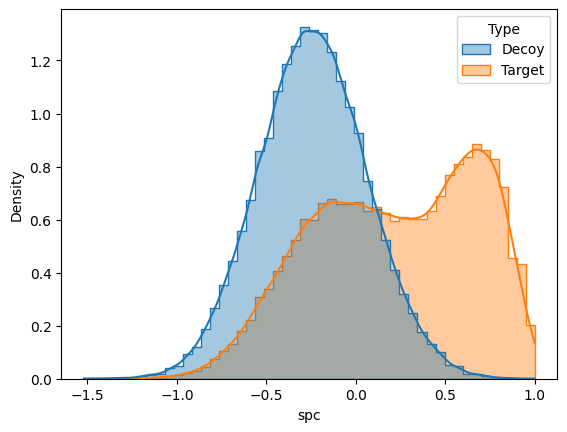

In [22]:
plot_target_decoy_dist(psm_df_with_features, metric='spc')

<Axes: xlabel='abs_rt_delta', ylabel='Density'>

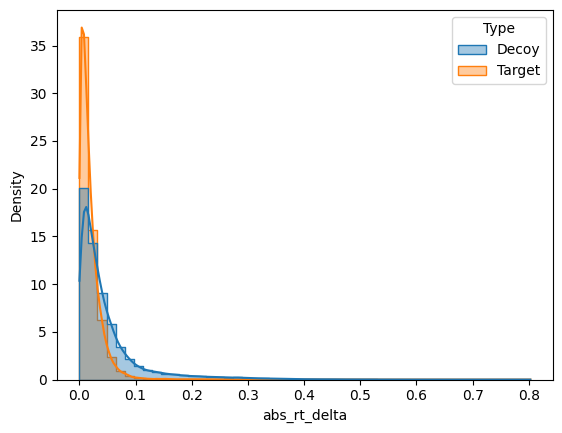

In [23]:
plot_target_decoy_dist(psm_df_with_features, metric='abs_rt_delta')

In [24]:
for feature in ms2_generator.feature_names + rt_generator.feature_names:
    print(f"Evaluating {feature}...")
    psm_df_eval = calc_fdr(psm_df_with_features, score_column=feature)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_target_decoy_dist(psm_df_eval, feature, ax=axes[0])
    axes[0].set_title(f'{feature} - Target/Decoy Distribution')
    
    threshold = 0.1
    if psm_df_eval['fdr'].min() > 0.1:
        threshold = 0.5
    plot_qvalues(psm_df_eval['fdr'], threshold=threshold, ax=axes[1])
    axes[1].set_title(f'{feature} - Discoveries at FDR')
    plt.tight_layout()
    
    pdf_path = output_dir / f'{feature}.pdf'
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.close()

Evaluating cos...
Evaluating sa...
Evaluating spc...
Evaluating pcc...
Evaluating cos_bion...
Evaluating sa_bion...
Evaluating spc_bion...
Evaluating pcc_bion...
Evaluating cos_yion...
Evaluating sa_yion...
Evaluating spc_yion...
Evaluating pcc_yion...
Evaluating merr_weighted_frag_score...
Evaluating pred_weighted_frag_score...
Evaluating merr_weighted_bion_score...
Evaluating pred_weighted_bion_score...
Evaluating merr_weighted_yion_score...
Evaluating pred_weighted_yion_score...
Evaluating matched_frag_num...
Evaluating matched_frag_ratio...
Evaluating both_matched_pred_frag_num...
Evaluating both_matched_pred_frag_to_matched...
Evaluating both_matched_pred_frag_to_pred...
Evaluating matched_not_pred_frag_num...
Evaluating matched_not_pred_frag_ratio...
Evaluating pred_not_matched_frag_num...
Evaluating pred_not_matched_frag_ratio...
Evaluating matched_frag_rel_to_pred...
Evaluating pred_frag_rel_to_matched...
Evaluating matched_bion_num...
Evaluating matched_bion_ratio...
Evaluatin


**Key Outputs:**
- Feature evaluation plots: `output/step_by_step/*.pdf`

